### 1. Import and Load Packages 

In [1]:
# Load packages
import pandas as pd
import numpy as np
from datetime import date
import csv
import re
import datetime
import os
from sklearn.feature_selection import VarianceThreshold
from pandas import read_csv
from datetime import date
import kaplanmeier as km

import datetime
from sklearn.decomposition import PCA
import pylab as pl
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
from qqman import qqman
import pandas as pd
from pandas_plink import read_plink
from scipy.stats import ttest_ind
import math
import os
from lifelines import KaplanMeierFitter
from pandas import DataFrame
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from numpy import set_printoptions
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import datasets
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
#from xgboost import XGBClassifier
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import pandas as pd
from google.cloud import bigquery
import os
import matplotlib.pyplot as plt
import textwrap
import re
from tqdm import tqdm
%matplotlib inline

### 2. Load cohorts from BigQuery 

##### exp_2022 and out_2022

In [2]:
user_id = 'kbechler'
nero_gcp_project = 'som-nero-nigam-starr'
cdm_project_id = 'som-nero-nigam-starr'
cdm_dataset_id = 'starr_omop_cdm5_deid_20211213'
work_project_id = 'som-nero-nigam-starr'
work_dataset_id = f'{user_id}_explore'
cdm_subset_dataset_id = 'cdm_subset'

Set up connection

In [3]:
# Use correct path whether you are local or Nero
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/kbechler/adc.json' 

# Set correct Nero project
os.environ['GCLOUD_PROJECT'] = nero_gcp_project
client = bigquery.Client(project = work_project_id)

In [4]:
sql = "select * from som-nero-nigam-starr.kbechler_explore.exp_2022"
exp_df = client.query(sql).to_dataframe()

sql = "select * from som-nero-nigam-starr.kbechler_explore.out_2022"
out_df = client.query(sql).to_dataframe()

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/google/cloud/bigquery/client.py:461: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [5]:
print("Number of patients in exposure cohort: ", len(exp_df))
print("Number of patients in outcome cohort:", len(out_df))

Number of patients in exposure cohort:  2853
Number of patients in outcome cohort: 363


### 3. Find first instance of LN diagnosis in positive cases

In [6]:
# Merge with condition df
condition_df = pd.read_csv('/home/kbechler/notebooks/data/condition_occurrence.tsv', sep='\t')

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (6,7,15,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
condition_df.head()

,_condition_name,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,Autoimmune disease,38425473,31141055,434621,2014-07-31,2014-07-31 00:00:00,2017-06-12,2017-06-12 00:00:00,38000245,NaN,NaN,NaN,NaN,279.49,44836939,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
1,Late effect of motor vehicle accident,87246961,31545787,438329,2017-10-01,2017-10-01 15:13:00,NaN,NaN,32019,NaN,NaN,117074992.0,NaN,V49.9XXS,45609521,Exempt from POA reporting,0,NaN,NaN,shc_hsp_acct_extinj_cd
2,Infectious mononucleosis,48416317,31140798,437784,2015-05-22,2015-05-22 00:00:00,2015-07-10,2015-07-10 00:00:00,38000245,NaN,NaN,NaN,NaN,075,44819380,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
3,Disorder of muscle,50469648,31671534,137275,2015-06-27,2015-06-27 00:00:00,2018-09-04,2018-09-04 00:00:00,38000245,NaN,NaN,NaN,NaN,729.1,44831524,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
4,Acute renal failure syndrome,48736185,30465198,197320,2015-06-19,2015-06-19 00:00:00,2015-08-02,2015-08-02 00:00:00,38000245,NaN,NaN,NaN,NaN,584.9,44826731,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list


Confirm proper number of patients have LN condition concept id

In [8]:
ln_condition = condition_df[condition_df.condition_concept_id == 4285717]
print("Number of patients with ln condition concept:", ln_condition.person_id.nunique())

Number of patients with ln condition concept: 363


Find minimum date of LN diagnosis per patient

In [9]:
# Group by unique person id and min condition concept ID for LN
ln_min = ln_condition.groupby('person_id', as_index = False)['condition_start_DATETIME'].min()
ln_min.columns = ['person_id', 'ln_diag_date']
print(len(ln_min))
print(sum(ln_min.ln_diag_date.isna()))
ln_min.head()

363
0


,person_id,ln_diag_date
0,29927202,2015-12-13 00:00:00
1,29927432,2016-06-16 00:00:00
2,29929485,2016-02-27 00:00:00
3,29934816,2016-07-14 15:30:00
4,29936481,2016-08-05 00:00:00


### 4. Create patient level dataframe 

In [10]:
# Merge with exp cohort
patient_df = pd.merge(exp_df, ln_min, left_on = 'subject_id', right_on = 'person_id', how = 'left')

In [11]:
print(len(patient_df))

2853


In [12]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,ln_diag_date
0,21,32209409,2011-08-12,2015-07-24,NaN,NaN
1,21,30924418,2011-09-27,2017-08-30,NaN,NaN
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28 08:58:00
3,21,30742058,2011-11-29,2019-10-07,NaN,NaN
4,21,32400899,2012-08-06,2021-03-02,NaN,NaN


In [13]:
sum(patient_df.ln_diag_date.notnull())

363

In [16]:
patient_df.dtypes

cohort_definition_id             int64
subject_id                       int64
cohort_start_date       datetime64[ns]
cohort_end_date                 object
person_id                      float64
ln_diag_date                    object
dtype: object

In [17]:
# Normalize diag data
patient_df['cohort_start_date'] = pd.to_datetime(patient_df['cohort_start_date']).dt.normalize()
patient_df['ln_diag_date'] = pd.to_datetime(patient_df['ln_diag_date']).dt.normalize()

In [18]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,ln_diag_date
0,21,32209409,2011-08-12,2015-07-24,NaN,NaT
1,21,30924418,2011-09-27,2017-08-30,NaN,NaT
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28
3,21,30742058,2011-11-29,2019-10-07,NaN,NaT
4,21,32400899,2012-08-06,2021-03-02,NaN,NaT


Check to see if patients need to be removed who have had LN diag date prior to cohort start date or same as 
cohort start date

In [19]:
# Calculate difference from first instance of SLE to first instance of LN
patient_df['time_sle_to_ln'] = pd.to_numeric((patient_df.ln_diag_date - patient_df.cohort_start_date).dt.days, 
                                             downcast = "integer")

In [20]:
patient_df.time_sle_to_ln.describe()

count     363.000000
mean     1813.382920
std      1215.310387
min         1.000000
25%       714.000000
50%      1886.000000
75%      2637.000000
max      5854.000000
Name: time_sle_to_ln, dtype: float64

In [21]:
print(sum(patient_df.time_sle_to_ln.isna()))

2490


In [22]:
print(sum(patient_df.time_sle_to_ln > 0))

363


In [78]:
patient_df.time_sle_to_ln.describe()

count     363.000000
mean     1813.382920
std      1215.310387
min         1.000000
25%       714.000000
50%      1886.000000
75%      2637.000000
max      5854.000000
Name: time_sle_to_ln, dtype: float64

### 5. Time from SLE to LN diagnosis  

In [23]:
os.getcwd()

'/home/kbechler/notebooks'

<Figure size 864x504 with 0 Axes>

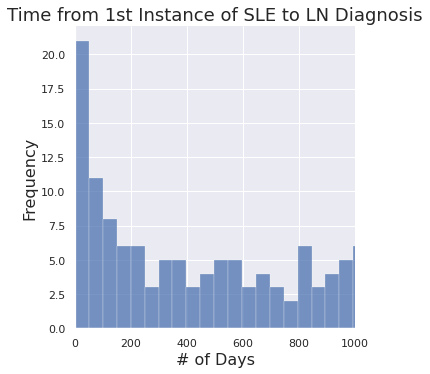

In [25]:
# Create bins of size 1
w = 50
n = math.ceil((patient_df.time_sle_to_ln.max() - patient_df.time_sle_to_ln.min())/w)


# Plot histogram of # days to SLE
plt.figure(figsize=(12,7))
sns.displot(patient_df['time_sle_to_ln'], kde = False, bins = n)
plt.title('Time from 1st Instance of SLE to LN Diagnosis', fontsize=18)
plt.xlabel('# of Days', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlim(0,1000)
plt.savefig('/home/kbechler/sle_to_ln.png')
plt.show()

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


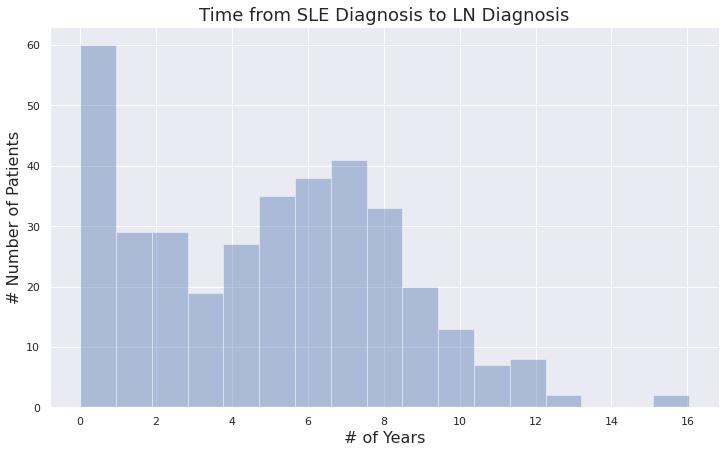

In [26]:
# Create bins of size 1
w = 1
n = math.ceil(((patient_df.time_sle_to_ln/365).max() - (patient_df.time_sle_to_ln/365).min())/w)


# Plot histogram of # days to SLE
plt.figure(figsize=(12,7))
sns.distplot(patient_df['time_sle_to_ln']/365, kde = False, bins = n)
plt.title('Time from SLE Diagnosis to LN Diagnosis', fontsize=18)
plt.xlabel('# of Years', fontsize=16)
plt.ylabel('# Number of Patients', fontsize=16)
#plt.xlim(0,50)
#plt.ylim = (0,1)
plt.savefig('/home/kbechler/sle_to_ln2.png')
plt.show()

In [27]:
person_df = pd.read_csv('/home/kbechler/notebooks/data/person.tsv', sep='\t')

In [28]:
len(person_df)

2853

In [29]:
patient_df_new = pd.merge(patient_df, person_df[['person_id', 'birth_DATETIME']], left_on = 'subject_id', 
                         right_on = 'person_id', how = 'left')

In [30]:
patient_df_new.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id_x,ln_diag_date,time_sle_to_ln,person_id_y,birth_DATETIME
0,21,32209409,2011-08-12,2015-07-24,NaN,NaT,NaN,32209409,1982-10-28 00:00:00
1,21,30924418,2011-09-27,2017-08-30,NaN,NaT,NaN,30924418,1954-12-23 00:00:00
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28,1960.0,31008811,1995-01-31 00:00:00
3,21,30742058,2011-11-29,2019-10-07,NaN,NaT,NaN,30742058,1968-05-01 00:00:00
4,21,32400899,2012-08-06,2021-03-02,NaN,NaT,NaN,32400899,1948-01-11 00:00:00


In [32]:
patient_df_new.dtypes

cohort_definition_id             int64
subject_id                       int64
cohort_start_date       datetime64[ns]
cohort_end_date                 object
person_id_x                    float64
ln_diag_date            datetime64[ns]
time_sle_to_ln                 float64
person_id_y                      int64
birth_DATETIME                  object
dtype: object

In [33]:
patient_df_new.birth_DATETIME = pd.to_datetime(patient_df_new.birth_DATETIME).dt.normalize()

In [34]:
# Subtract birth_DATETIME from cohort_start_date to get age of patient in years
patient_df_new['age'] = pd.to_numeric((patient_df_new.cohort_start_date - patient_df_new.birth_DATETIME).dt.days, 
downcast = 'integer')

In [35]:
patient_df_new.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id_x,ln_diag_date,time_sle_to_ln,person_id_y,birth_DATETIME,age
0,21,32209409,2011-08-12,2015-07-24,NaN,NaT,NaN,32209409,1982-10-28,10515
1,21,30924418,2011-09-27,2017-08-30,NaN,NaT,NaN,30924418,1954-12-23,20732
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28,1960.0,31008811,1995-01-31,5707
3,21,30742058,2011-11-29,2019-10-07,NaN,NaT,NaN,30742058,1968-05-01,15917
4,21,32400899,2012-08-06,2021-03-02,NaN,NaT,NaN,32400899,1948-01-11,23584


/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


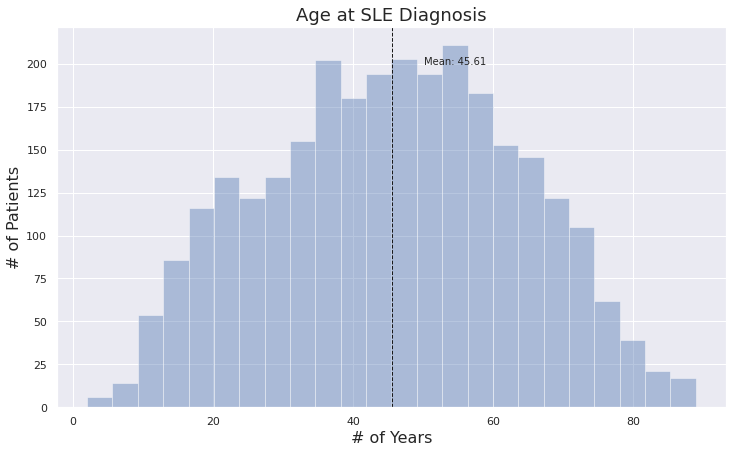

In [36]:
plt.figure(figsize=(12,7))
sns.distplot(patient_df_new['age']/365, kde = False)
plt.title('Age at SLE Diagnosis', fontsize=18)
plt.xlabel('# of Years', fontsize=16)
plt.ylabel('# of Patients', fontsize=16)
plt.axvline((patient_df_new['age']/365).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text((patient_df_new['age']/365).mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format((patient_df_new['age']/365).mean()))
plt.savefig('/home/kbechler/sle_age.png')
plt.show()

### 6. Create Venn Diagram for SLE Cohort looking at condition vs. ICD vs. notes 

##### Original exposure cohort with sql from ATLAS 

In [37]:
user_id = 'kbechler'
nero_gcp_project = 'som-nero-nigam-starr'
cdm_project_id = 'som-nero-nigam-starr'
cdm_dataset_id = 'starr_omop_cdm5_deid_20211213'
work_project_id = 'som-nero-nigam-starr'
work_dataset_id = f'{user_id}_explore'
cdm_subset_dataset_id = 'cdm_subset'
cohort_table_id = 'exp_cohort'
cohort_id = 21

In [38]:
sql = "select * from som-nero-nigam-starr.kbechler_explore.exp_cohort"
atlas_exp_cohort = client.query(sql).to_dataframe()

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/google/cloud/bigquery/client.py:461: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [39]:
import matplotlib_venn as venn
from matplotlib_venn import venn3
from matplotlib_venn import venn2

In [40]:
# Filter to person_id by condition_occurrence SLE per STARR_OMOP
# Condition codes
# 4055640: Lung disease with systemic lupus erythematosus
# 4344158: Systemic lupus erythematosus with organ/system involvement
# 4285717: SLE glomerulopehritis syndrome
# 4063581: Drug-induced systemic lupus erythematosus
# 4149913: Systemic lupus erythematosus with pericarditis
# 257628: Systemic lupus erythematosus

In [41]:
# Condition occurrence of SLE
# Mapped and descendants
sle_condition_list = [4055640, 4344158, 4285717 , 4063581, 4149913, 257628]

In [42]:
# Read in data from condition occurrence table
sql = """SELECT * 
FROM `som-nero-nigam-starr.starr_omop_cdm5_deid_20211213.condition_occurrence`
WHERE condition_concept_id IN (4055640, 4344158, 4285717 , 4063581, 4149913, 257628)"""
sle_condition = client.query(sql).to_dataframe()

In [43]:
# Count how many times each patient has condition occurrence associated with SLE
sle_condition_count = sle_condition.groupby(['person_id'], as_index = False).agg({
    'condition_occurrence_id': 'count'
})

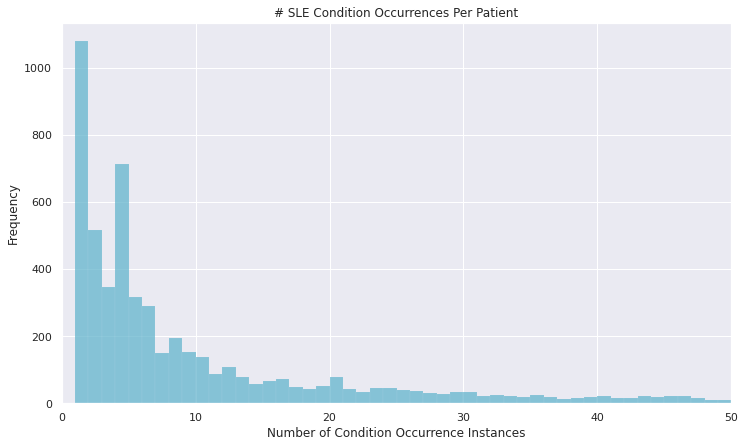

In [44]:
# Draw histogram
# Create bins
w = 1
n = math.ceil((sle_condition_count.condition_occurrence_id.max() - sle_condition_count.condition_occurrence_id.min())/w)


# Plot histogram
plt.figure(figsize = (12, 7))
sns.histplot(sle_condition_count['condition_occurrence_id'], kde = False, color = 'c' , bins = n)
plt.title('# SLE Condition Occurrences Per Patient')
plt.xlabel('Number of Condition Occurrence Instances')
plt.ylabel('Frequency')
plt.xlim(0,50)
plt.show()

In [45]:
print("Number of patients with SLE condition occurrence <= 1:", sum(sle_condition_count.condition_occurrence_id <=1))
print("Number of patients with SLE condition occurrence > 1:", sum(sle_condition_count.condition_occurrence_id >1))

Number of patients with SLE condition occurrence <= 1: 1080
Number of patients with SLE condition occurrence > 1: 5351


In [46]:
# Filter to person_id by ICD9/ICD10 diagnoses
# ICD10 = M32.9
# ICD9 = 710.0

# Read data from condition occurrence table
sql = """SELECT * 
FROM `som-nero-nigam-starr.starr_omop_cdm5_deid_20211213.condition_occurrence`
WHERE condition_source_value IN ('M32.9', '710.0')"""
sle_icd = client.query(sql).to_dataframe()

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/google/cloud/bigquery/client.py:461: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [47]:
print("Number of unique patients with ICD occurrence:", len(sle_icd.person_id.unique()))

Number of unique patients with ICD occurrence: 5976


In [48]:
# Count number of times ICD code occurs per patient
sle_icd_count = sle_icd.groupby(['person_id'], as_index = False).agg({
    'condition_source_value': 'count'
})

In [49]:
sle_icd_count.head()

,person_id,condition_source_value
0,29923372,301
1,29924282,10
2,29925496,1
3,29927014,72
4,29927175,26


In [50]:
print("Number of patients with <= 1 ICD SLE mention:", sum(sle_icd_count.condition_source_value <= 1))
print("Number of patients with > 1 ICD SLE mention:", sum(sle_icd_count.condition_source_value > 1))

Number of patients with <= 1 ICD SLE mention: 1129
Number of patients with > 1 ICD SLE mention: 4847


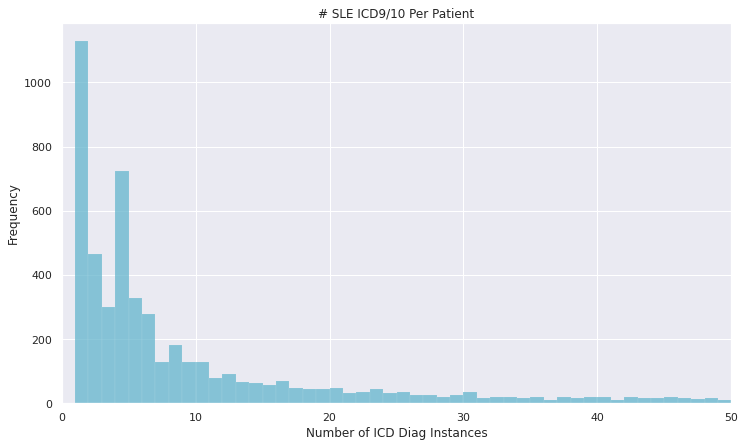

In [51]:
# Draw histogram
# Create bins
w = 1
n = math.ceil((sle_icd_count.condition_source_value.max() - sle_icd_count.condition_source_value.min())/w)


# Plot histogram
plt.figure(figsize = (12, 7))
sns.histplot(sle_icd_count['condition_source_value'], kde = False, color = 'c' , bins = n)
plt.title('# SLE ICD9/10 Per Patient')
plt.xlabel('Number of ICD Diag Instances')
plt.ylabel('Frequency')
plt.xlim(0,50)
plt.show()

In [52]:
# Create Venn Diagram
def venn_diagram(condition, icd, labels = ['condition', 'icd']):
    
    a = list(set(condition))
    b = list(set(icd))

    only_a = len([x for x in a if x not in b])
    only_b = len([x for x in b if x not in a])
    print(only_a)
    print(only_b)
    
    a_b = len(np.intersect1d(a, b))
    print(a_b)
    
    venn2(subsets = (only_a, only_b, a_b), set_labels=labels)

455
0
5976


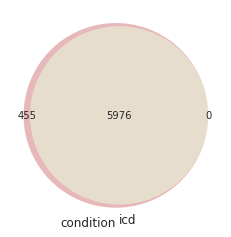

In [53]:
venn_diagram(sle_condition.person_id,sle_icd.person_id)
plt.savefig('/home/kbechler/VennDiagram2_4_5.png')
plt.show()

In [54]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,ln_diag_date,time_sle_to_ln
0,21,32209409,2011-08-12,2015-07-24,NaN,NaT,NaN
1,21,30924418,2011-09-27,2017-08-30,NaN,NaT,NaN
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28,1960.0
3,21,30742058,2011-11-29,2019-10-07,NaN,NaT,NaN
4,21,32400899,2012-08-06,2021-03-02,NaN,NaT,NaN


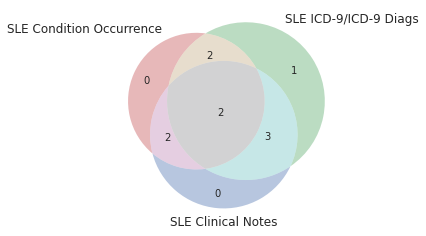

In [55]:
# Build 3 category venn diagram
def venn_diagram(condition, icd, notes, labels = ['SLE Condition Occurrence', 'SLE ICD-9/ICD-9 Diags', 'SLE Clinical Notes']):
    a = list(set(condition))
    b = list(set(icd))
    c = list(set(notes))
    
    only_a = len([x for x in a if x not in b+c])
    only_b = len([x for x in b if x not in a+c])
    only_c = len([x for x in c if x not in a+b])
    
    a_b = len(np.intersect1d(a,b))
    a_c = len(np.intersect1d(a,c))
    b_c = len(np.intersect1d(b,c))
    
    a_b_c = len([x for x in a if (x in b) and (x in c)])
    venn3(subsets = (only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)   
    

venn_diagram([1, 2], [1, 2, 3, 4], [1, 2, 3])

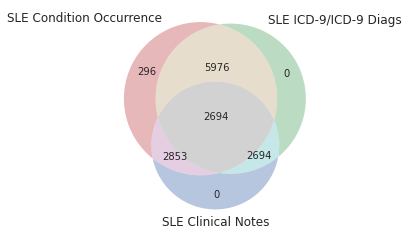

In [56]:
venn_diagram(sle_condition.person_id,sle_icd.person_id, patient_df.subject_id)
plt.savefig('/home/kbechler/VennDiagram_3_31.png')
plt.show()

### 7. Look at patient numbers for multiple prediction models vs. survival model or single prediction model 

In [57]:
# Multiple predictions fixed interval
# Current patient dataframe
print("Number of SLE patients:", len(patient_df))
print("Number of LN patients:", len(patient_df[patient_df.ln_diag_date.notna()]))

Number of SLE patients: 2853
Number of LN patients: 363


In [58]:
# Create index 0 date = first instance of SLE diagnosis
patient_df['index_0'] = patient_df['cohort_start_date']

In [59]:
patient_df['ln_event_0'] = np.where(patient_df['time_sle_to_ln'] <= 365, 1, 0)

In [60]:
sum(patient_df.ln_event_0)

63

In [61]:
from datetime import datetime, timedelta

In [62]:
# Create index 1 date = 1 year from first instance of SLE diagnosis
patient_df['index_1'] = patient_df['index_0'] + timedelta(days = 365)

In [63]:
patient_df['ln_event_1'] = np.where((patient_df['time_sle_to_ln'] > 365) & (patient_df['time_sle_to_ln'] <= 730), 1, 0)
patient_df['ln_event_1'] = np.where((patient_df['ln_event_0'] == 1), np.nan, patient_df['ln_event_1'])

In [64]:
print(patient_df.ln_event_1.sum(skipna = True))
print(len(patient_df[patient_df.ln_event_1 == 0]))
print(sum(patient_df.ln_event_1.isna()))

29.0
2761
63


In [65]:
patient_df['index_2'] = patient_df['index_1'] + timedelta(days = 365)
patient_df['index_3'] = patient_df['index_2'] + timedelta(days = 365)
patient_df['index_4'] = patient_df['index_3'] + timedelta(days = 365)
patient_df['index_5'] = patient_df['index_4'] + timedelta(days = 365)

In [66]:
patient_df['index_6'] = patient_df['index_5'] + timedelta(days = 365)
patient_df['index_7'] = patient_df['index_6'] + timedelta(days = 365)
patient_df['index_8'] = patient_df['index_7'] + timedelta(days = 365)
patient_df['index_9'] = patient_df['index_8'] + timedelta(days = 365)

In [67]:
patient_df['ln_event_2'] = np.where((patient_df['time_sle_to_ln'] > 730) & (patient_df['time_sle_to_ln'] <= 1095), 1, 0)
patient_df['ln_event_2'] = np.where((patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_2'])


patient_df['ln_event_3'] = np.where((patient_df['time_sle_to_ln'] > 1095) & (patient_df['time_sle_to_ln'] <= 1490), 1, 0)
patient_df['ln_event_3'] = np.where((patient_df['ln_event_2'] == 1) |(patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_3'])

patient_df['ln_event_4'] = np.where((patient_df['time_sle_to_ln'] > 1490) & (patient_df['time_sle_to_ln'] <= 1825), 1, 0)
patient_df['ln_event_4'] = np.where((patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_4'])

patient_df['ln_event_5'] = np.where((patient_df['time_sle_to_ln'] > 1825) & (patient_df['time_sle_to_ln'] <= 2190), 1, 0)
patient_df['ln_event_5'] = np.where((patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_5'])


patient_df['ln_event_6'] = np.where((patient_df['time_sle_to_ln'] > 2190) & (patient_df['time_sle_to_ln'] <= 2555), 1, 0)
patient_df['ln_event_6'] = np.where((patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_6'])


patient_df['ln_event_7'] = np.where((patient_df['time_sle_to_ln'] > 2555) & (patient_df['time_sle_to_ln'] <= 2920), 1, 0)
patient_df['ln_event_7'] = np.where((patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_7'])


patient_df['ln_event_8'] = np.where((patient_df['time_sle_to_ln'] > 2920) & (patient_df['time_sle_to_ln'] <= 3285), 1, 0)
patient_df['ln_event_8'] = np.where((patient_df['ln_event_7'] == 1) |(patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_8'])


patient_df['ln_event_9'] = np.where((patient_df['time_sle_to_ln'] > 3285) & (patient_df['time_sle_to_ln'] <= 3650), 1, 0)
patient_df['ln_event_9'] = np.where((patient_df['ln_event_8'] == 1) |(patient_df['ln_event_7'] == 1) |(patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_9'])


patient_df['ln_event_10'] = np.where((patient_df['time_sle_to_ln'] > 3650) & (patient_df['time_sle_to_ln'] <= 4015), 1, 0)
patient_df['ln_event_10'] = np.where((patient_df['ln_event_9'] == 1) |(patient_df['ln_event_8'] == 1) |(patient_df['ln_event_7'] == 1) |(patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_10'])


patient_df['ln_event_11'] = np.where((patient_df['time_sle_to_ln'] > 4015) & (patient_df['time_sle_to_ln'] <= 4380), 1, 0)
patient_df['ln_event_11'] = np.where((patient_df['ln_event_10'] == 1) |(patient_df['ln_event_9'] == 1) |(patient_df['ln_event_8'] == 1) |(patient_df['ln_event_7'] == 1) |(patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_11'])


patient_df['ln_event_12'] = np.where((patient_df['time_sle_to_ln'] > 4380) & (patient_df['time_sle_to_ln'] <= 4745), 1, 0)
patient_df['ln_event_12'] = np.where((patient_df['ln_event_11'] == 1) |(patient_df['ln_event_10'] == 1) |(patient_df['ln_event_9'] == 1) |(patient_df['ln_event_8'] == 1) |(patient_df['ln_event_7'] == 1) |(patient_df['ln_event_6'] == 1) |(patient_df['ln_event_5'] == 1) |(patient_df['ln_event_4'] == 1) |(patient_df['ln_event_3'] == 1) |(patient_df['ln_event_2'] == 1) | (patient_df['ln_event_1'] == 1) | (patient_df['ln_event_0'] == 1), np.nan,patient_df['ln_event_12'])


In [68]:
# Create dataframe
one_year_predictions = pd.DataFrame()

In [69]:
row = (len(patient_df),patient_df.ln_event_0.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

In [70]:
row = (len(patient_df) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_1.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_2.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_3.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 ==1])- len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_4.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_4 == 1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_5.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_5 == 1]) - len(patient_df[patient_df.ln_event_4 == 1]) - len(patient_df[patient_df.ln_event_3 ==1]) - len(patient_df[patient_df.ln_event_2 ==1]) - len(patient_df[patient_df.ln_event_1 ==1]) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_6.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_6 == 1]) - len(patient_df[patient_df.ln_event_5 == 1]) - len(patient_df[patient_df.ln_event_4 == 1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_7.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_7 == 1]) - len(patient_df[patient_df.ln_event_6 ==1]) - len(patient_df[patient_df.ln_event_5 ==1]) - len(patient_df[patient_df.ln_event_4 == 1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 ==1]) - len(patient_df[patient_df.ln_event_1 ==1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_8.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_8 == 1]) - len(patient_df[patient_df.ln_event_7 == 1]) - len(patient_df[patient_df.ln_event_6 == 1])- len(patient_df[patient_df.ln_event_5 == 1]) - len(patient_df[patient_df.ln_event_4 == 1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 == 1]),patient_df.ln_event_9.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_9 == 1]) - len(patient_df[patient_df.ln_event_8 == 1]) - len(patient_df[patient_df.ln_event_7 == 1]) - len(patient_df[patient_df.ln_event_6 == 1]) - len(patient_df[patient_df.ln_event_5 == 1]) - len(patient_df[patient_df.ln_event_4 ==1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 == 1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_10.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_10 == 1]) - len(patient_df[patient_df.ln_event_9 ==1]) - len(patient_df[patient_df.ln_event_8 ==1]) - len(patient_df[patient_df.ln_event_7 == 1])- len(patient_df[patient_df.ln_event_6 ==1])- len(patient_df[patient_df.ln_event_5 ==1]) - len(patient_df[patient_df.ln_event_4 ==1])- len(patient_df[patient_df.ln_event_3 ==1])- len(patient_df[patient_df.ln_event_2 ==1]) - len(patient_df[patient_df.ln_event_1 ==1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_11.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

row = (len(patient_df) - len(patient_df[patient_df.ln_event_11 == 1]) - len(patient_df[patient_df.ln_event_10 ==1]) - len(patient_df[patient_df.ln_event_9 == 1]) - len(patient_df[patient_df.ln_event_8 == 1]) - len(patient_df[patient_df.ln_event_7 ==1]) - len(patient_df[patient_df.ln_event_6 ==1]) - len(patient_df[patient_df.ln_event_5 ==1]) - len(patient_df[patient_df.ln_event_4 ==1]) - len(patient_df[patient_df.ln_event_3 == 1]) - len(patient_df[patient_df.ln_event_2 == 1]) - len(patient_df[patient_df.ln_event_1 ==1]) - len(patient_df[patient_df.ln_event_0 ==1]),patient_df.ln_event_12.sum(skipna = True))
row = pd.Series(row)
one_year_predictions = one_year_predictions.append(row, ignore_index = True )

In [71]:
one_year_predictions.head()

,0,1
0,2853.0,63.0
1,2790.0,29.0
2,2761.0,26.0
3,2735.0,34.0
4,2701.0,25.0


In [72]:
one_year_predictions.columns = ['sle_patients', 'ln_event_patients']

In [76]:
one_year_predictions['ln_cum'] = one_year_predictions.ln_event_patients.cumsum()

In [73]:
print(sum(patient_df.ln_event_0))
print(patient_df.ln_event_1.sum(skipna = True))
print(patient_df.ln_event_2.sum(skipna = True))
print(patient_df.ln_event_3.sum(skipna = True))
print(patient_df.ln_event_4.sum(skipna = True))
print(patient_df.ln_event_5.sum(skipna = True))
print(patient_df.ln_event_6.sum(skipna = True))
print(patient_df.ln_event_7.sum(skipna = True))
print(patient_df.ln_event_8.sum(skipna = True))
print(patient_df.ln_event_9.sum(skipna = True))
print(patient_df.ln_event_10.sum(skipna = True))
print(patient_df.ln_event_11.sum(skipna = True))
print(patient_df.ln_event_12.sum(skipna = True))

63
29.0
26.0
34.0
25.0
32.0
50.0
34.0
30.0
20.0
8.0
5.0
5.0


In [77]:
one_year_predictions

,sle_patients,ln_event_patients,ln_cum
0,2853.0,63.0,63.0
1,2790.0,29.0,92.0
2,2761.0,26.0,118.0
3,2735.0,34.0,152.0
4,2701.0,25.0,177.0
5,2676.0,32.0,209.0
6,2644.0,50.0,259.0
7,2594.0,34.0,293.0
8,2560.0,30.0,323.0
9,2530.0,20.0,343.0


In [79]:
# Number of patients who will develop LN in 1 year?
# Number of patient who will develop LN in the next 2 years?
# Next 3 years?
# Next 4 years?
# Next 5 years?
patient_df['ln_1year'] = np.where(patient_df['time_sle_to_ln'] <= 365, 1, 0)
patient_df['ln_2years'] = np.where(patient_df['time_sle_to_ln'] <= 730, 1, 0)
patient_df['ln_3years'] = np.where(patient_df['time_sle_to_ln'] <= 1095, 1, 0)
patient_df['ln_4years'] = np.where(patient_df['time_sle_to_ln'] <= 1460, 1, 0)
patient_df['ln_5years'] = np.where(patient_df['time_sle_to_ln'] <= (365*5), 1, 0)
patient_df['ln_6years'] = np.where(patient_df['time_sle_to_ln'] <= (365*6), 1, 0)
patient_df['ln_7years'] = np.where(patient_df['time_sle_to_ln'] <= (365*7), 1, 0)
patient_df['ln_8years'] = np.where(patient_df['time_sle_to_ln'] <= (365*8), 1, 0)
patient_df['ln_9years'] = np.where(patient_df['time_sle_to_ln'] <= (365*9), 1, 0)
patient_df['ln_10years'] = np.where(patient_df['time_sle_to_ln'] <= (365*10), 1, 0)
patient_df['ln_11years'] = np.where(patient_df['time_sle_to_ln'] <= (365*11), 1, 0)
patient_df['ln_12years'] = np.where(patient_df['time_sle_to_ln'] <= (365*12), 1, 0)

In [80]:
# Create dataframe
multiple_year_predictions = pd.DataFrame()

In [81]:
row = (len(patient_df),patient_df.ln_1year.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

In [82]:
row = (len(patient_df),patient_df.ln_2years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_3years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_4years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_5years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_6years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_7years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )


row = (len(patient_df),patient_df.ln_8years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_9years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_10years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_11years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )

row = (len(patient_df),patient_df.ln_12years.sum(skipna = True))
row = pd.Series(row)
multiple_year_predictions = multiple_year_predictions.append(row, ignore_index = True )


In [87]:
multiple_year_predictions['year'] = np.arange(start = 1, stop = 13, step = 1)

In [88]:
multiple_year_predictions.columns = ['sle_patients', 'ln_events', 'year']

In [90]:
multiple_year_predictions

,sle_patients,ln_events,year
0,2853.0,63.0,1
1,2853.0,92.0,2
2,2853.0,118.0,3
3,2853.0,148.0,4
4,2853.0,177.0,5
5,2853.0,209.0,6
6,2853.0,259.0,7
7,2853.0,293.0,8
8,2853.0,323.0,9
9,2853.0,343.0,10


In [91]:
# Export dataframes
multiple_year_predictions.to_csv('/home/kbechler/multiple_year_predictions_2022.csv', index = False)
one_year_predictions.to_csv('/home/kbechler/one_year_predictions_2022.csv', index = False)

##### Make plots

In [92]:
labels = ['index_0', 'index_1', 'index_2', 'index_3', 'index_4', 'index_5', 'index_6', 'index_7', 'index_8', 
         'index_9', 'index_10', 'index_11', 'index_12']

In [93]:
num_sle_patients = one_year_predictions.sle_patients
num_ln_patients = one_year_predictions.ln_event_patients

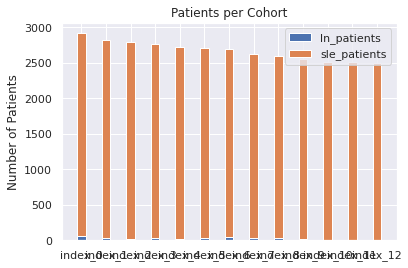

In [94]:
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, num_ln_patients, width, label = "ln_patients")
ax.bar(labels, num_sle_patients, width, label = "sle_patients", bottom = num_ln_patients)

ax.set_ylabel('Number of Patients')
ax.set_title('Patients per Cohort')
ax.legend()


plt.show()

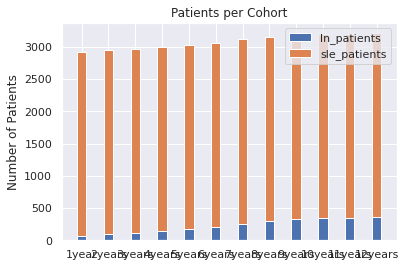

In [96]:
labels = ['1year', '2years', '3years', '4years', '5years', '6years', '7years', '8years', '9years', '10years', 
         '11years', '12years']
list(multiple_year_predictions)

num_sle_patients = multiple_year_predictions['sle_patients']
num_ln_patients = multiple_year_predictions['ln_events']

width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, num_ln_patients, width, label = "ln_patients")
ax.bar(labels, num_sle_patients, width, label = "sle_patients", bottom = num_ln_patients)

ax.set_ylabel('Number of Patients')
ax.set_title('Patients per Cohort')
ax.legend()


plt.show()

In [116]:
patient_df.groupby('ln_event').count()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id_x,ln_diag_date,time_sle_to_ln,index_0,ln_event_0,index_1,...,ln_7years,ln_8years,ln_9years,ln_10years,ln_11years,ln_12years,person_id_y,observation_period_end_DATE,observation_post_sle_obs,event_date
ln_event,,,,,,,,,,,,,,,,,,,,,
0,2490,2490,2490,2490,0,0,0,2490,2490,2490,...,2490,2490,2490,2490,2490,2490,2490,2490,2490,2490
1,363,363,363,363,363,363,363,363,363,363,...,363,363,363,363,363,363,363,363,363,363


### 8. Kaplan Meier Curve 

In [97]:
# Get full observation window
sql = "select * from som-nero-nigam-starr.cdm_subset.observation_period"
observation_period = client.query(sql).to_dataframe()

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/google/cloud/bigquery/client.py:461: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [98]:
len(observation_period)

2853

In [99]:
# Merge with patient_df
list(observation_period)

['_period_type_name',
 'observation_period_id',
 'person_id',
 'observation_period_start_DATE',
 'observation_period_end_DATE',
 'period_type_concept_id',
 'trace_id',
 'unit_id',
 'load_table_id']

In [100]:
patient_df = pd.merge(patient_df, observation_period[['person_id', 'observation_period_end_DATE']],left_on = 'subject_id',
                     right_on = 'person_id', how = 'inner')

In [101]:
len(patient_df)

2853

In [102]:
# Convert to datetime
patient_df.observation_period_end_DATE = pd.to_datetime(patient_df.observation_period_end_DATE)

In [103]:
patient_df['observation_post_sle_obs'] = pd.to_numeric((patient_df.observation_period_end_DATE - 
                                                        patient_df.cohort_start_date).dt.days, downcast = "integer")

<Figure size 864x504 with 0 Axes>

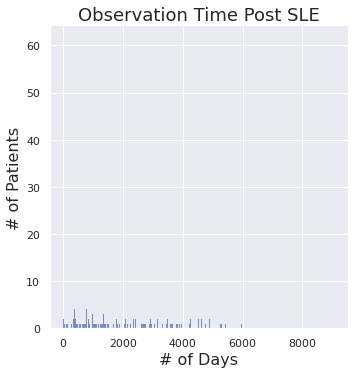

In [104]:
# Create bins of size 1
w = 1
n = math.ceil((patient_df.observation_post_sle_obs.max() - patient_df.observation_post_sle_obs.min())/w)


# Plot histogram of # days to SLE
plt.figure(figsize=(12,7))
sns.displot(patient_df['observation_post_sle_obs'], kde = False, bins = n)
plt.title('Observation Time Post SLE', fontsize=18)
plt.xlabel('# of Days', fontsize=16)
plt.ylabel('# of Patients', fontsize=16)
#plt.xlim(0,)
plt.savefig('/home/kbechler/sle_to_end_obs.png')
plt.show()

In [105]:
# Create "event_date"
# If patient doesn't have ln diag, event date is last observation date of patient
patient_df['event_date'] = np.where(patient_df.time_sle_to_ln.isna(), patient_df.observation_post_sle_obs,
                                   patient_df.time_sle_to_ln)

In [106]:
patient_df.event_date.describe()

count    2853.000000
mean     1888.841220
std      1422.593098
min         0.000000
25%       688.000000
50%      1624.000000
75%      2813.000000
max      9056.000000
Name: event_date, dtype: float64

In [107]:
kmf = KaplanMeierFitter()

In [108]:
patient_df['ln_event'] = np.where(patient_df.time_sle_to_ln.isna(), 0, 1)

In [109]:
kmf.fit(durations = patient_df['event_date'], event_observed = patient_df['ln_event'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2853 total observations, 2490 right-censored observations>

In [110]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,61,0,61,2853,2853
1.0,7,1,6,0,2792
2.0,6,0,6,0,2785
3.0,4,0,4,0,2779
4.0,1,0,1,0,2775
...,...,...,...,...,...
7151.0,1,0,1,0,5
7493.0,1,0,1,0,4
7557.0,1,0,1,0,3


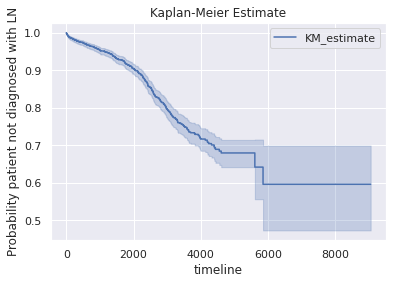

The median survival time:  inf


In [111]:
# Plot the graph
kmf.plot()
plt.title("Kaplan-Meier Estimate")
plt.ylabel("Probability patient not diagnosed with LN")
plt.savefig('/home/kbechler/km_test.png')
plt.show()
print("The median survival time: " ,kmf.median_survival_time_)

<AxesSubplot:xlabel='timeline'>

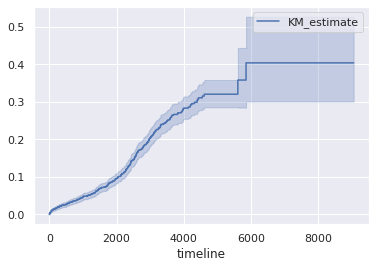

In [117]:
kmf.plot_cumulative_density()

### 9. Export patient dataframe for labels with patients to get LN in x years 

In [118]:
 patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id_x,ln_diag_date,time_sle_to_ln,index_0,ln_event_0,index_1,...,ln_8years,ln_9years,ln_10years,ln_11years,ln_12years,person_id_y,observation_period_end_DATE,observation_post_sle_obs,event_date,ln_event
0,21,32209409,2011-08-12,2015-07-24,NaN,NaT,NaN,2011-08-12,0,2012-08-11,...,0,0,0,0,0,32209409,2015-07-24,1442,1442.0,0
1,21,30924418,2011-09-27,2017-08-30,NaN,NaT,NaN,2011-09-27,0,2012-09-26,...,0,0,0,0,0,30924418,2017-08-30,2164,2164.0,0
2,21,31008811,2010-09-16,2019-01-24,31008811.0,2016-01-28,1960.0,2010-09-16,0,2011-09-16,...,1,1,1,1,1,31008811,2019-01-24,3052,1960.0,1
3,21,30742058,2011-11-29,2019-10-07,NaN,NaT,NaN,2011-11-29,0,2012-11-28,...,0,0,0,0,0,30742058,2019-10-07,2869,2869.0,0
4,21,32400899,2012-08-06,2021-03-02,NaN,NaT,NaN,2012-08-06,0,2013-08-06,...,0,0,0,0,0,32400899,2021-03-02,3130,3130.0,0


In [119]:
patient_df.to_csv('/home/kbechler/patient_df_labels_2022.csv', index = False)